# Multi-Task Cascading CNN

In [145]:
from mtcnn import MTCNN
import cv2

detector = MTCNN()

img = cv2.imread('images/vk.jpg')

output = detector.detect_faces(img)
output

[{'box': [191, 50, 78, 99],
  'confidence': 0.9999390840530396,
  'keypoints': {'nose': [230, 103],
   'mouth_right': [244, 127],
   'right_eye': [249, 85],
   'left_eye': [213, 83],
   'mouth_left': [215, 126]}}]

In [146]:

for i in output:
    x,y,widht,height = i['box']

    left_eyeX,left_eyeY = i['keypoints']['left_eye']
    right_eyeX,right_eyeY = i['keypoints']['right_eye']
    noseX,noseY = i['keypoints']['nose']
    mouth_leftX,mouth_leftY = i['keypoints']['mouth_left']
    mouth_rightX,mouth_rightY = i['keypoints']['mouth_right']


    cv2.circle(img,center=(left_eyeX,left_eyeY),color=(255,0,0),thickness=3,radius=2)
    cv2.circle(img,center=(right_eyeX,right_eyeY),color=(255,0,0),thickness=3,radius=2)
    cv2.circle(img,center=(noseX,noseY),color=(255,0,0),thickness=3,radius=2)
    cv2.circle(img,center=(mouth_leftX,mouth_leftY),color=(255,0,0),thickness=3,radius=2)
    cv2.circle(img,center=(mouth_rightX,mouth_rightY),color=(255,0,0),thickness=3,radius=2)

    cv2.rectangle(img,pt1=(x,y),pt2=(x+widht,y+height),color=(255,0,0),thickness=3)
cv2.imshow('window',img)

cv2.waitKey(0)



-1

In [4]:
#MTCNN on Video
import cv2
from mtcnn import MTCNN

cap = cv2.VideoCapture(0)
detector = MTCNN()

while True:

    ret,frame = cap.read()

    output = detector.detect_faces(frame)

    for single_output in output:
        x,y,width,height = single_output['box']
        cv2.rectangle(frame,pt1=(x,y),pt2=(x+width,y+height),color=(255,0,0),thickness=3)

    cv2.imshow('win',frame)

    if cv2.waitKey(1) & 0xFF == ord('x'):
        break

cv2.destroyAllWindows()

## Introduction to MTCNN

### 1. History of MTCNN

![MTCNN Pipeline](https://kpzhang93.github.io/MTCNN_face_detection_alignment/support/index.png)

*Figure 1: The MTCNN Pipeline for face detection.*

MTCNN (Multitask Cascaded Convolutional Networks) was first introduced in a 2016 paper titled *"Joint Face Detection and Alignment Using Multitask Cascaded Convolutional Networks"* by Kaipeng Zhang, Zhanpeng Zhang, Zhifeng Li, and Yu Qiao. This work was published in the *IEEE Signal Processing Letters* and later presented at the *2017 IEEE International Conference on Computer Vision (ICCV)*. 

The method quickly became popular due to its ability to perform both face detection and facial landmark alignment in a single pipeline. It was designed to efficiently detect faces at different scales and orientations while also predicting key facial landmarks such as eyes, nose, and mouth. This multitask approach reduced the computational cost compared to running separate models for face detection and alignment.

### 2. The MTCNN Method

MTCNN uses a cascaded structure of three convolutional neural networks (CNNs) that work together to progressively refine face proposals and detect key landmarks. The networks are:

- **PNet (Proposal Network)**: This network scans the image at different scales to generate candidate face regions (bounding boxes).
- **RNet (Refinement Network)**: RNet takes the candidate face regions from PNet, refines them by filtering false positives, and regresses the bounding boxes.
- **ONet (Output Network)**: The final stage, ONet, further refines the bounding boxes and detects five facial landmarks: the eyes, nose, and the corners of the mouth.

The overall process is hierarchical, with each network focusing on more precise tasks as the proposal gets closer to the final face detection. This cascading structure helps balance accuracy and speed, ensuring high performance even in challenging conditions like varying lighting, pose, and facial occlusions.

Here’s an illustration of the architecture:

![MTCNN Architecture](https://www.researchgate.net/profile/Alem-Fitwi/publication/341148320/figure/fig3/AS:887674495844353@1588649500279/MTCNN-Stage-architecture-of-the-model-used-for-face-detection-and-landmark-extraction.jpg)

*Figure 2: The MTCNN architecture consists of three networks (PNet, RNet, and ONet) that progressively refine face detection and alignment.*

### 3. History of This Package

The original implementation of MTCNN was released in 2018 as an open-source project based on the original paper. Since then, it has been widely adopted in various computer vision tasks involving face detection and alignment, with many libraries and applications using the MTCNN model.

In 2024, a major refactor and optimization of the MTCNN package was undertaken to modernize the codebase, making it more robust, efficient, and compatible with the latest versions of TensorFlow (>2.17). Key improvements include:

- A cleaner project structure with modular components for better maintainability.
- Support for batch processing to handle multiple images at once.
- Removal of outdated dependencies like OpenCV, switching to TensorFlow for image processing.
- Full documentation and optimized performance through matrix-based operations.

This version of MTCNN retains the simplicity of the original interface while providing more flexibility and support for a broader range of use cases.


# Architecture
## 1. Networks and Stages in MTCNN

MTCNN (Multitask Cascaded Convolutional Networks) is a powerful framework for face detection and alignment, built around three main networks: **PNet**, **RNet**, and **ONet**. These networks are organized into distinct *stages*, each refining the output of the previous one. Together, they enable MTCNN to achieve high accuracy in face detection and landmark alignment.

### Overview of Stages and Networks

The MTCNN pipeline consists of three stages:

- **Stage 1 (PNet)**: The Proposal Network stage, where initial candidate face regions are generated.
- **Stage 2 (RNet)**: The Refinement Network stage, where these proposals are refined and filtered.
- **Stage 3 (ONet)**: The Output Network stage, where the final bounding boxes and facial landmarks are predicted.

Each stage includes the following key operations:

1. **Image pyramid scaling** (in Stage 1 only).
2. **Face detection and bounding box regression**.
3. **Non-Maximum Suppression (NMS)** with thresholds to filter out overlapping and low-confidence boxes.
4. **Landmark regression** (in Stage 3).

Now, let’s break down each stage and its corresponding network.

---

### 1. Stage 1: PNet and Image Pyramid Construction

#### Function of Stage 1

The first stage of MTCNN uses the **Proposal Network (PNet)** to scan the image at multiple scales. Since faces can appear at different sizes, the input image is **scaled down progressively** to create an *image pyramid*. This allows PNet to detect faces at various sizes across the image.

At each scale, PNet slides over the image and generates **bounding box proposals** for regions that might contain faces. These proposals include:

- **Bounding Box Regressions**: Initial estimates for the bounding boxes.
- **Face/Non-Face Classification**: A score indicating whether a region contains a face or not.

#### Image Pyramid and Proposal Generation

1. **Image Pyramid Construction**: The input image is scaled down multiple times, forming an image pyramid. Each scale produces a resized image, and the smallest scale ensures that even small faces are detected.
   
2. **PNet Processing**: For each scaled image, PNet scans regions using a sliding window, proposing candidate face regions and outputting bounding boxes and confidence scores.
   
3. **Scale-Specific NMS**: For each scale, PNet outputs a set of candidate regions. These are processed with **Non-Maximum Suppression (NMS)** to remove overlapping boxes that likely represent the same face. A **threshold** controls how aggressive the NMS is at filtering boxes.

4. **Aggregate Proposals Across Scales**: The candidate boxes from all scales are combined into a single list. NMS is applied again to merge overlapping detections across scales, ensuring that only the best bounding boxes remain.

#### Strengths of PNet
- The image pyramid ensures detection of faces at multiple scales.
- PNet is fast and efficient, generating many face proposals in a short amount of time.

```text
Input Image -> Image Pyramid -> PNet -> Scale-specific NMS -> Combined Proposals -> Final NMS
```

---

### 2. Stage 2: RNet (Refinement Network)

#### Function of Stage 2

After the proposals from PNet are filtered through NMS, they are passed to the **Refinement Network (RNet)**. The purpose of RNet is to further refine these bounding boxes, rejecting **false positives** and improving the precision of the face regions. Like PNet, RNet performs:

- **Bounding Box Regression**: Adjusts the bounding boxes to better fit the faces.
- **Face/Non-Face Classification**: Classifies whether each region contains a face or not.

#### Key Operations in RNet

1. **Input from PNet**: The refined proposals from PNet are cropped from the original image and resized to a standard size before being fed into RNet.
   
2. **Bounding Box Refinement**: RNet processes these regions and further refines the bounding box coordinates, producing a more accurate estimate of where the face is located.
   
3. **Face Classification and NMS**: RNet classifies each region as face or non-face and applies another round of **NMS** to filter out overlapping or low-confidence detections. This stage also has a specific **NMS threshold**, which controls how strictly overlapping boxes are filtered.

#### Strengths of RNet
- RNet provides more accurate bounding box predictions and reduces false positives.
- The additional round of NMS refines the proposals from PNet, resulting in better precision.

```text
Refined Proposals -> RNet -> Bounding Box Refinement -> NMS -> Refined Detections
```

---

### 3. Stage 3: ONet (Output Network)

#### Function of Stage 3

In the final stage, the **Output Network (ONet)** refines the bounding boxes even further and detects **five facial landmarks** (eyes, nose, and mouth corners). ONet provides three outputs:

- **Bounding Box Regression**: Final adjustments to the bounding boxes.
- **Face/Non-Face Classification**: Classifies whether a region contains a face or not.
- **Landmark Regression**: Predicts the positions of five facial landmarks for each face.

#### Key Operations in ONet

1. **Input from RNet**: The refined regions from RNet are again cropped and resized to the appropriate input size for ONet.
   
2. **Final Bounding Box Refinement**: ONet produces the final adjustments to the bounding boxes, ensuring maximum accuracy in detecting the face regions.

3. **Facial Landmark Detection**: In addition to bounding boxes, ONet predicts the coordinates of five key landmarks (left eye, right eye, nose, left mouth corner, right mouth corner).

4. **NMS with Landmark Consideration**: The final round of **NMS** is applied, but this time the landmark predictions are also taken into account when merging overlapping boxes. The NMS threshold is tuned to preserve the best bounding boxes and corresponding landmarks.

#### Strengths of ONet
- ONet provides highly accurate face detection results, as well as landmark predictions that are essential for facial alignment tasks.
- The final NMS ensures that the best bounding boxes and landmarks are kept while filtering redundant detections.

```text
Final Proposals -> ONet -> Bounding Box Refinement -> Landmark Detection -> NMS -> Final Bounding Boxes + Landmarks
```

---

### Thresholds and Non-Maximum Suppression (NMS)

Throughout the MTCNN pipeline, **Non-Maximum Suppression (NMS)** is a key operation used to filter overlapping bounding boxes. Each stage of the network applies NMS after detecting face proposals. NMS removes redundant boxes by keeping only the box with the highest confidence score when there are multiple overlapping boxes representing the same face. 

At each stage, a **threshold** is applied to control how aggressively NMS filters the proposals:

- **PNet NMS Threshold**: This threshold is more lenient to keep as many proposals as possible in the early stage.
- **RNet NMS Threshold**: A stricter threshold is used to discard false positives and refine the bounding boxes.
- **ONet NMS Threshold**: The strictest threshold is used to produce the final high-confidence detections.



# Usage of each Stage

# 1.MTCNN PNet

This notebook demonstrates the PNet architecture and its corresponding weights.

PNet is a fully convolutional neural network (CNN) used in the first stage of MTCNN. This network processes inputs of variable size and generates bounding box proposals. It produces two outputs:

* Regression of the bounding box coordinates within the convolutional receptive field.
* Classification of the receptive field into two categories: no-face or face.

The outputs are generated for each receptive field, meaning that with every convolutional pass, a corresponding output is produced.

In the following sections, we will run the MTCNN model, focusing solely on the PNet stage. We will examine the intermediate inputs, observe the output shapes, and visualize the results.

## MTCNN on PNet Stage

MTCNN can be configured to run only up to the first stage, which will provide the direct output of the PNet stage.

In [37]:
from mtcnn import MTCNN
from mtcnn.utils.images import load_image
#from mtcnn.utils.tensorflow import set_gpu_memory_growth
from mtcnn.stages import StagePNet

In [38]:
# To avoid using excessive GPU memory (In case of using GPU)
s#et_gpu_memory_growth()

In [39]:
image = load_image("images/babar.jfif")

In [40]:
mtcnn = MTCNN(stages=[StagePNet], device="CPU:0")    # other devices: GPU:0  ,  GPU:1  , ...

In [41]:
%%time
result = mtcnn.detect_faces(image, postprocess=True)

CPU times: total: 156 ms
Wall time: 169 ms


In [42]:
result

[{'box': [162, 31, 40, 40], 'confidence': 0.9999701976776123},
 {'box': [150, 30, 49, 49], 'confidence': 0.9995822310447693},
 {'box': [62, 42, 35, 35], 'confidence': 0.999232292175293},
 {'box': [158, 42, 40, 40], 'confidence': 0.9988920092582703},
 {'box': [148, 34, 35, 35], 'confidence': 0.9982576966285706},
 {'box': [162, 56, 25, 25], 'confidence': 0.9928489923477173},
 {'box': [165, 58, 19, 19], 'confidence': 0.9883279204368591},
 {'box': [186, 65, 29, 29], 'confidence': 0.9861117601394653},
 {'box': [159, 44, 31, 31], 'confidence': 0.9794731736183167},
 {'box': [255, 74, 41, 41], 'confidence': 0.9781046509742737},
 {'box': [189, 30, 21, 21], 'confidence': 0.9744958281517029},
 {'box': [163, 50, 20, 20], 'confidence': 0.9692676067352295},
 {'box': [173, 32, 22, 22], 'confidence': 0.9688071012496948},
 {'box': [173, 31, 27, 27], 'confidence': 0.9678125381469727},
 {'box': [190, 70, 18, 18], 'confidence': 0.9671353697776794},
 {'box': [37, 13, 59, 59], 'confidence': 0.96677720546722

The output of the processing is a set of bounding boxes along with a confidence score. We can see a plot of the output in the following cell:

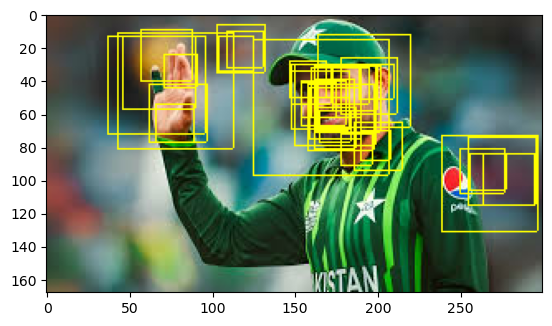

In [43]:
from mtcnn.utils.plotting import plot
import matplotlib.pyplot as plt

plt.imshow(plot(image, result))

As can be seen, the PNet is proposing several bounding boxes, which must be "refined" to discard those that do not fit. This is part of the RNet functionality.

### Accessing PNet's model

The network can be accessed by instantiating StagePNet and reading the attribute `model`, which is a TensorFlow model.

In [44]:
stage = StagePNet()
model = stage.model

In [45]:
model.summary()

Model: "p_net_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                       │ ?                           │             280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ prelu1 (PReLU)                       │ ?                           │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpooling1 (MaxPooling2D)           │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ ?                           │           1,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ prelu2 (PReLU)                       │ ?                           │              16 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ ?                           │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ prelu3 (PReLU)                       │ ?                           │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv4-1 (Conv2D)                     │ ?                           │             132 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv4-2 (Conv2D)                     │ ?                           │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,632 (25.91 KB)

 Trainable params: 6,632 (25.91 KB)

 Non-trainable params: 0 (0.00 B)

# 2. MTCNN RNet

This notebook demonstrates the RNet architecture and its corresponding weights.

RNet is a convolutional neural network (CNN) with fully connected layers (FC) used in the second stage of MTCNN. This network refines the bounding box proposals generated by the previous PNet stage. It produces two outputs:

* Regression of the bounding box coordinates to further refine the initial proposals.
* Classification of the proposals into two categories: no-face or face.

The outputs are generated for each bounding box proposal, refining the results from the previous stage.  
While RNet has the same functionality as PNet, it processes each proposal individually, with a fixed-size input, using the crops from the output of the previous stage as input.

In the following sections, we will run the MTCNN model, focusing solely on the RNet stage. We will examine the intermediate inputs, observe the output shapes, and visualize the results.

## MTCNN on RNet Stage

MTCNN can be configured to run up to the second stage, which will provide the direct output of the RNet stage.

In [46]:
from mtcnn import MTCNN
from mtcnn.utils.images import load_image
from mtcnn.stages import StagePNet, StageRNet

In [48]:
image = load_image("images/babar.jfif")

In [49]:
mtcnn = MTCNN(stages=[StagePNet, StageRNet], device="CPU:0")

In [50]:
%%time
result = mtcnn.detect_faces(image, postprocess=True)

CPU times: total: 234 ms
Wall time: 232 ms


In [51]:
result

[{'box': [147, 25, 54, 54], 'confidence': 0.9988892674446106},
 {'box': [136, 13, 70, 70], 'confidence': 0.9913395047187805},
 {'box': [34, 13, 68, 68], 'confidence': 0.9141918420791626}]

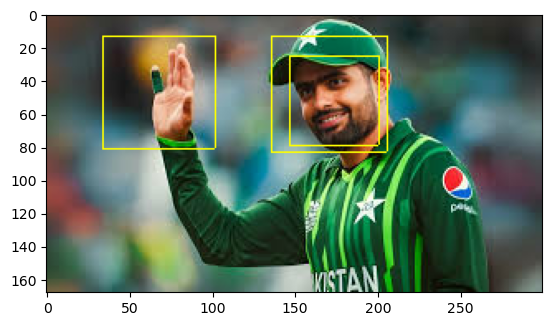

In [52]:
from mtcnn.utils.plotting import plot
import matplotlib.pyplot as plt

plt.imshow(plot(image, result))

As can be seen, the RNet is refining proposals by discarding those that do not match the thresholds, and adjusting those that matched.

### Accessing RNet's model

The network can be accessed by instantiating StageRNet and reading the attribute `model`, which is a TensorFlow model.

In [53]:
stage = StageRNet()
model = stage.model

In [54]:
model.summary()

Model: "r_net_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                       │ ?                           │             784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ prelu1 (PReLU)                       │ ?                           │              28 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpooling1 (MaxPooling2D)           │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ ?                           │          12,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ prelu2 (PReLU)                       │ ?                           │              48 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpooling2 (MaxPooling2D)           │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ ?                           │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ prelu3 (PReLU)                       │ ?                           │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ permute (Permute)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten3 (Flatten)                   │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc4 (Dense)                          │ ?                           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ prelu4 (PReLU)                       │ ?                           │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc5-1 (Dense)                        │ ?                           │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc5-2 (Dense)                        │ ?                           │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 100,178 (391.32 KB)

 Trainable params: 100,178 (391.32 KB)

 Non-trainable params: 0 (0.00 B)

# 3. MTCNN ONet

This notebook demonstrates the ONet architecture and its corresponding weights.

ONet is a fully convolutional neural network (CNN) used in the third and final stage of MTCNN. This network further refines the bounding box proposals generated by the previous RNet stage and adds facial landmark detection. It produces three outputs:

* Regression of the bounding box coordinates to fine-tune the proposals.
* Classification of the proposals into two categories: no-face or face.
* Detection of five facial landmarks (eyes, nose, and mouth corners).

The outputs are generated for each bounding box proposal, providing more precise detections and facial landmarks.

In the following sections, we will run the MTCNN model, focusing solely on the ONet stage. We will examine the intermediate inputs, observe the output shapes, and visualize the results.

## MTCNN on ONet Stage

MTCNN can be configured to run up to the third stage, which will provide the direct output of the ONet stage, including refined bounding boxes and facial landmarks.


In [55]:
from mtcnn import MTCNN
from mtcnn.utils.images import load_image
from mtcnn.stages import StagePNet, StageRNet, StageONet

In [56]:
image = load_image("images/babar.jfif")

In [57]:
# This is the default configuration of stages, aliased as "face_and_landmarks_detection"
mtcnn = MTCNN(stages=[StagePNet, StageRNet, StageONet], device="CPU:0")

In [58]:
%%time
result = mtcnn.detect_faces(image, postprocess=True, threshold_onet=0.85)

CPU times: total: 234 ms
Wall time: 244 ms


In [59]:
result

[{'box': [149, 26, 47, 53],
  'confidence': 0.9998607635498047,
  'keypoints': {'nose': [165, 56],
   'mouth_right': [181, 60],
   'right_eye': [175, 40],
   'left_eye': [157, 46],
   'mouth_left': [164, 66]}}]

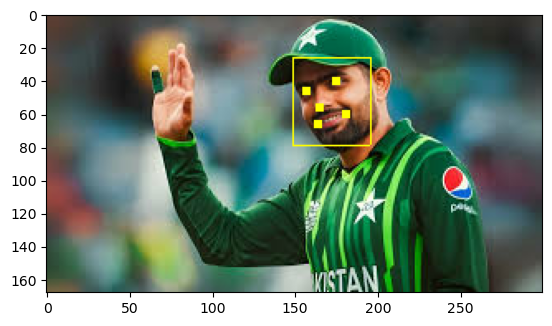

In [60]:
from mtcnn.utils.plotting import plot
import matplotlib.pyplot as plt

plt.imshow(plot(image, result))

# MTCNN on Dataset for Face Recognition

In [64]:
import cv2

In [129]:
img = cv.imread("dataset/asim/9.jpeg")
# opencv BGR channel format and plt reads images as RGB channel format

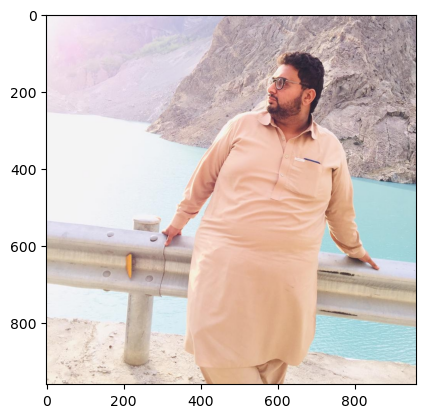

In [130]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [131]:
from mtcnn.mtcnn import MTCNN

detector = MTCNN()
results = detector.detect_faces(img)

In [132]:
results

[{'box': [568, 129, 96, 132],
  'confidence': 0.9890201687812805,
  'keypoints': {'nose': [580, 196],
   'mouth_right': [596, 230],
   'right_eye': [615, 179],
   'left_eye': [587, 175],
   'mouth_left': [575, 226]}}]

In [133]:
x,y,w,h = results[0]['box']

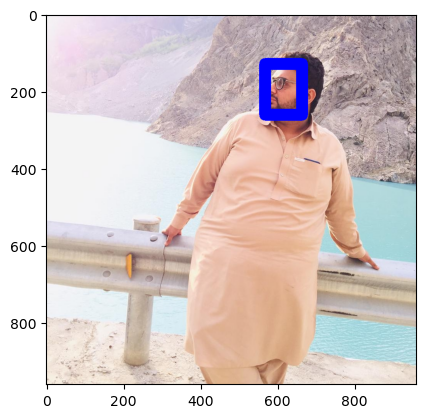

In [134]:
img = cv2.rectangle(img, (x,y), (x+w, y+h), (0,0,255), 30)
plt.imshow(img)

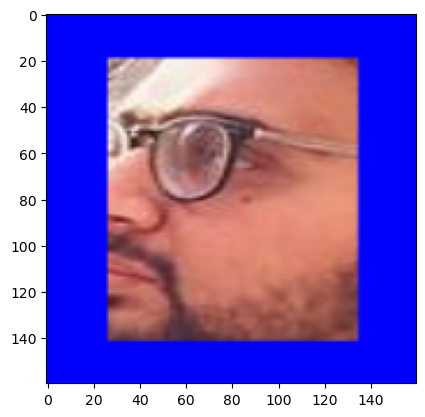

In [135]:
my_face = img[y:y+h, x:x+w]
#Facenet takes as input 160x160 
my_face = cv2.resize(my_face, (160,160))
plt.imshow(my_face)

In [136]:
my_face

array([[[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       ...,

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]]

## Automate the preprocessing 

In [85]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from mtcnn import MTCNN

class FACELOADING:
    def __init__(self, directory):
        self.directory = directory
        self.target_size = (160, 160)
        self.X = []
        self.Y = []
        self.detector = MTCNN()
    
    def extract_face(self, filename):
        try:
            img = cv.imread(filename)
            if img is None:
                print(f"Failed to load image: {filename}")
                return None
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            detections = self.detector.detect_faces(img)
            if not detections:
                print(f"No face detected in {filename}")
                return None
            x, y, w, h = detections[0]['box']
            x, y = abs(x), abs(y)
            face = img[y:y+h, x:x+w]
            face_arr = cv.resize(face, self.target_size)
            return face_arr
        except Exception as e:
            print(f"Error processing {filename}: {e}")
            return None
    
    def load_faces(self, dir):
        FACES = []
        for im_name in os.listdir(dir):
            if im_name.lower().endswith(('.jpg', '.jpeg', '.png')):  # Ensure it's an image file
                path = os.path.join(dir, im_name)
                single_face = self.extract_face(path)
                if single_face is not None:
                    FACES.append(single_face)
        return FACES

    def load_classes(self):
        for sub_dir in os.listdir(self.directory):
            sub_dir_path = os.path.join(self.directory, sub_dir)
            if os.path.isdir(sub_dir_path):  # Check if it's a directory
                FACES = self.load_faces(sub_dir_path)
                labels = [sub_dir for _ in range(len(FACES))]
                print(f"Loaded {len(FACES)} faces from class '{sub_dir}'")
                self.X.extend(FACES)
                self.Y.extend(labels)
        
        self.X = np.asarray(self.X)
        self.Y = np.asarray(self.Y)
        return self.X, self.Y

    def plot_images(self):
        plt.figure(figsize=(18, 16))
        ncols = 3
        nrows = len(self.X) // ncols + 1
        for num, image in enumerate(self.X):
            plt.subplot(nrows, ncols, num + 1)
            plt.imshow(image)
            plt.axis('off')
        plt.show()

# Usage
directory = "./dataset"  # Adjust this to the folder path in the same directory as the notebook
faceloading = FACELOADING(directory)
X, Y = faceloading.load_classes()

print(f"Total images loaded: {len(X)}")
print(f"Labels: {set(Y)}")


Loaded 10 faces from class 'asim'
Loaded 9 faces from class 'jenna_ortega'
Loaded 8 faces from class 'robert_downey'
Loaded 10 faces from class 'sardor_abdirayimov'
Loaded 8 faces from class 'taylor_swift'
Total images loaded: 45
Labels: {'taylor_swift', 'asim', 'robert_downey', 'sardor_abdirayimov', 'jenna_ortega'}


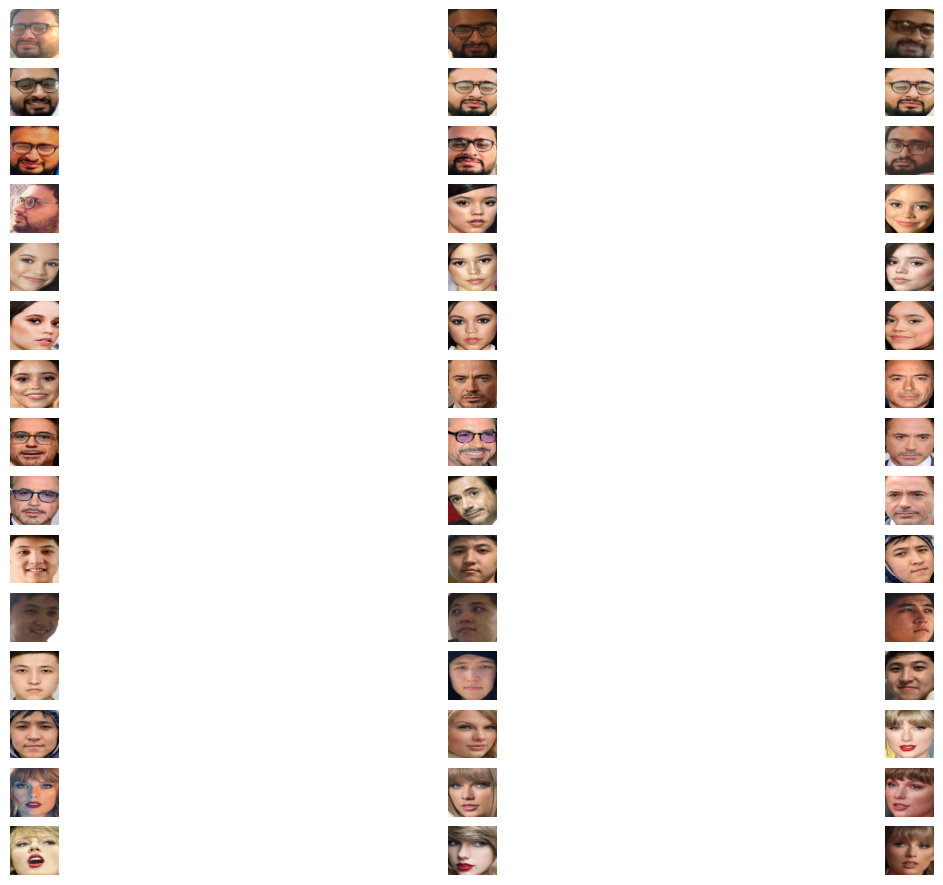

In [86]:
plt.figure(figsize=(16,12))
for num,image in enumerate(X):
    ncols = 3
    nrows = len(Y)//ncols + 1
    plt.subplot(nrows,ncols,num+1)
    plt.imshow(image)
    plt.axis('off')

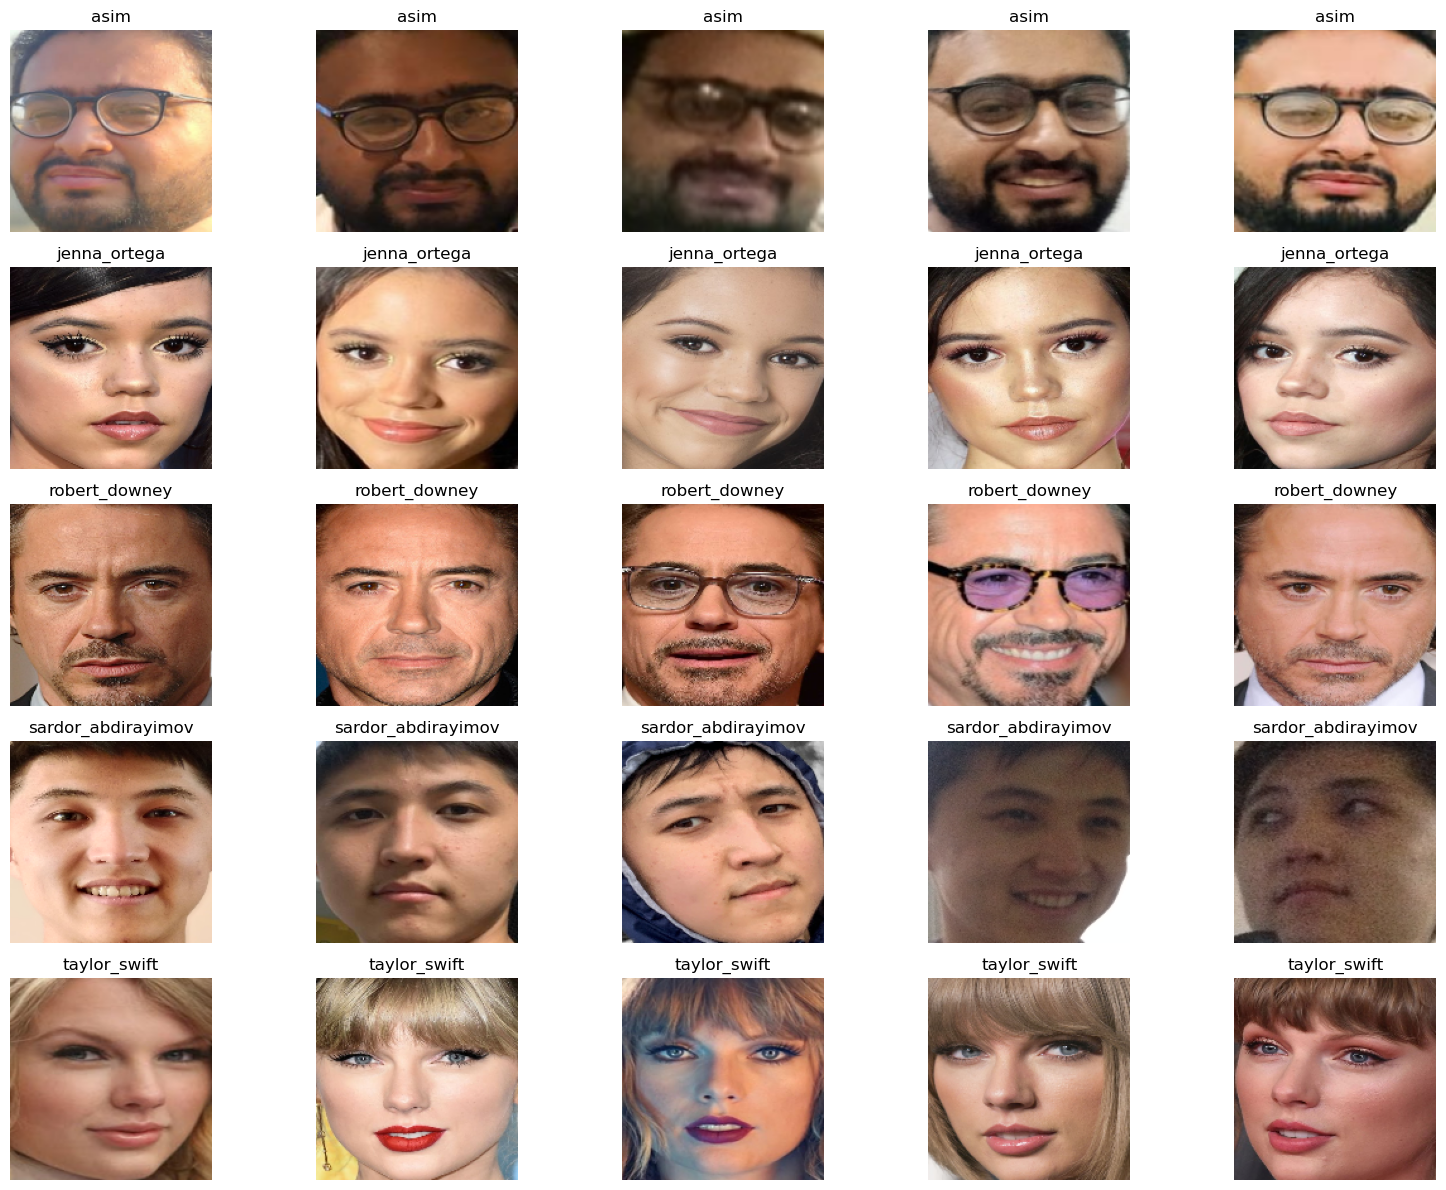

In [88]:
#import matplotlib.pyplot as plt
from collections import defaultdict

# Create a mapping of labels to their images
class_to_images = defaultdict(list)
for image, label in zip(X, Y):
    class_to_images[label].append(image)

# Plot 5 images from each class
plt.figure(figsize=(16, 12))

ncols = 5  # Number of images to display per row
num_classes = len(class_to_images)
nrows = num_classes  # One row for each class

image_index = 1
for label, images in class_to_images.items():
    selected_images = images[:5]  # Select first 5 images from the class
    for img in selected_images:
        plt.subplot(nrows, ncols, image_index)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
        image_index += 1

plt.tight_layout()
plt.show()


## FaceNet part 

In [90]:
!pip install keras-facenet

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10388 sha256=33cec6ee062030d295526fd87eb1c3db1864c1b5b96909e7c81ef8f529033ca7
  Stored in directory: c:\users\asim\appdata\local\pip\cache\wheels\99\94\dd\cb1a65a7440ba6d508bd24346c15af0b1d24ff8b1cdb1c9959
Successfully built keras-facenet


In [92]:
from keras_facenet import FaceNet
embedder = FaceNet()

def get_embedding(face_img):
    face_img = face_img.astype('float32') # 3D(160x160x3)
    face_img = np.expand_dims(face_img, axis=0) 
    # 4D (Nonex160x160x3)
    yhat= embedder.embeddings(face_img)
    return yhat[0] # 512D image (1x1x512)

In [93]:
EMBEDDED_X = []

for img in X:
    EMBEDDED_X.append(get_embedding(img))

EMBEDDED_X = np.asarray(EMBEDDED_X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━

In [94]:
np.savez_compressed('faces_embeddings_done_5classes.npz', EMBEDDED_X, Y)

## SVM model 


In [95]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)

Text(0, 0.5, '0')

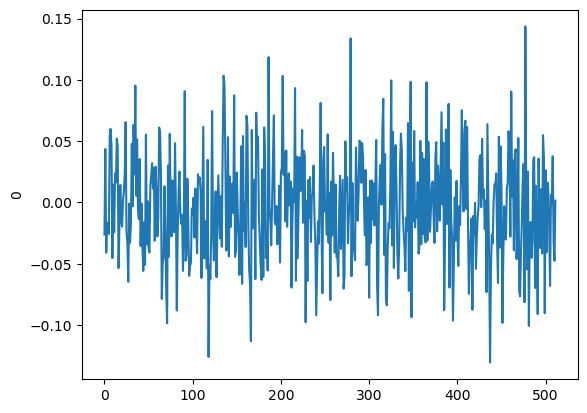

In [96]:
plt.plot(EMBEDDED_X[0]) 
plt.ylabel(Y[0])

In [98]:
Y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4,
       4])

In [99]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(EMBEDDED_X, Y, shuffle=True, random_state=17)

In [100]:
from sklearn.svm import SVC
model = SVC(kernel='linear', probability=True)
model.fit(X_train, Y_train)

SVC(kernel='linear', probability=True)

In [101]:
ypreds_train = model.predict(X_train)
ypreds_test = model.predict(X_test)

In [102]:
from sklearn.metrics import accuracy_score

accuracy_score(Y_train, ypreds_train)

1.0

In [103]:
accuracy_score(Y_test,ypreds_test)

1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00         3

    accuracy                           1.00        33
   macro avg       1.00      1.00      1.00        33
weighted avg       1.00      1.00      1.00        33



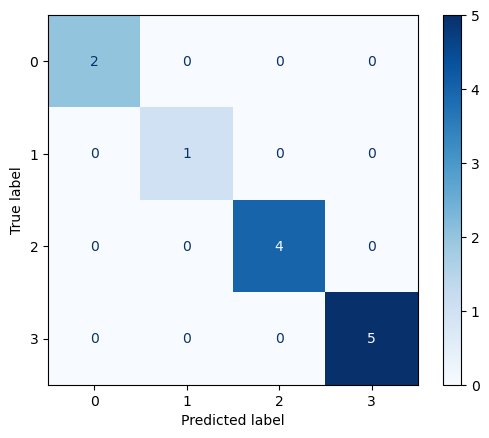

In [141]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
# Compute confusion matrix
cm = confusion_matrix(Y_test, ypreds_test )

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

# Classification report
print("Classification Report:")
print(classification_report(Y_train, ypreds_train))


In [108]:
t_im = cv2.imread("images/babar.jfif")
t_im = cv2.cvtColor(t_im, cv2.COLOR_BGR2RGB)
x,y,w,h = detector.detect_faces(t_im)[0]['box']

In [109]:
t_im = t_im[y:y+h, x:x+w]
t_im = cv.resize(t_im, (160,160))
test_im = get_embedding(t_im)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


In [110]:
test_im = [test_im]
ypreds = model.predict(test_im)

In [111]:
ypreds

array([0])

In [112]:
encoder.inverse_transform(ypreds)

array(['asim'], dtype='<U18')

In [113]:
import pickle
#save the model
with open('svm_model_160x160.pkl','wb') as f:
    pickle.dump(model,f)

In [118]:
# IMPORTS
import cv2 as cv
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import pickle
from keras_facenet import FaceNet
from mtcnn import MTCNN

# INITIALIZE
facenet = FaceNet()
detector = MTCNN()  # Initialize MTCNN for face detection
faces_embeddings = np.load("faces_embeddings_done_5classes.npz")
Y = faces_embeddings['arr_1']
encoder = LabelEncoder()
encoder.fit(Y)
model = pickle.load(open("svm_model_160x160.pkl", 'rb'))

cap = cv.VideoCapture(0)  # Change to 0 if the external camera is not in use

# WHILE LOOP
while cap.isOpened():
    _, frame = cap.read()
    rgb_img = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    
    # Detect faces using MTCNN
    results = detector.detect_faces(rgb_img)
    
    for result in results:
        x, y, w, h = result['box']
        x, y = abs(x), abs(y)  # Ensure no negative values
        face = rgb_img[y:y+h, x:x+w]
        
        # Preprocess the detected face
        face = cv.resize(face, (160, 160))
        face = np.expand_dims(face, axis=0)
        
        # Get embeddings and predict the class
        embedding = facenet.embeddings(face)
        face_name = model.predict(embedding)
        final_name = encoder.inverse_transform(face_name)[0]
        
        # Draw bounding box and label
        cv.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 255), 2)
        cv.putText(frame, str(final_name), (x, y - 10), cv.FONT_HERSHEY_SIMPLEX,
                   1, (0, 0, 255), 2, cv.LINE_AA)

    # Display the frame
    cv.imshow("Face Recognition:", frame)
    if cv.waitKey(1) & 0xFF == ord('q'):  # Exit loop on pressing 'q'
        break

cap.release()
cv.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━

In [148]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Set a similarity threshold (you may need to tune this)
SIMILARITY_THRESHOLD = 0.6
cap = cv.VideoCapture(0)
# WHILE LOOP
while cap.isOpened():
    _, frame = cap.read()
    rgb_img = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    
    # Detect faces using MTCNN
    results = detector.detect_faces(rgb_img)
    
    for result in results:
        x, y, w, h = result['box']
        x, y = abs(x), abs(y)  # Ensure no negative values
        face = rgb_img[y:y+h, x:x+w]
        
        # Preprocess the detected face
        face = cv.resize(face, (160, 160))
        face = np.expand_dims(face, axis=0)
        
        # Get embeddings for the detected face
        embedding = facenet.embeddings(face)
        
        # Measure similarity with embeddings of known faces
        similarities = cosine_similarity(embedding, faces_embeddings['arr_0'])  # arr_0 contains embeddings
        max_similarity = np.max(similarities)  # Get the highest similarity score
        
        if max_similarity > SIMILARITY_THRESHOLD:
            # Identify the face if similarity exceeds the threshold
            face_name = model.predict(embedding)
            final_name = encoder.inverse_transform(face_name)[0]
        else:
            # Mark the face as "unknown"
            final_name = "Unknown"
        
        # Draw bounding box and label
        cv.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 255), 2)
        cv.putText(frame, str(final_name), (x, y - 10), cv.FONT_HERSHEY_SIMPLEX,
                   1, (0, 0, 255), 2, cv.LINE_AA)

    # Display the frame
    cv.imshow("Face Recognition:", frame)
    if cv.waitKey(1) & 0xFF == ord('q'):  # Exit loop on pressing 'q'
        break

cap.release()
cv.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

In [147]:
import cv2
from mtcnn import MTCNN
import numpy as np

# Initialize webcam and MTCNN detector
cap = cv2.VideoCapture(0)
detector = MTCNN()

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Detect faces in the current frame
    output = detector.detect_faces(frame)

    for single_output in output:
        # Get the bounding box of the detected face
        x, y, width, height = single_output['box']
        x, y = max(0, x), max(0, y)  # Ensure bounding box is within the frame

        # Extract the face region
        face_region = frame[y:y+height, x:x+width]

        # Apply a Gaussian blur to the face region
        blurred_face = cv2.GaussianBlur(face_region, (51, 51), 30)

        # Replace the original face with the blurred face
        frame[y:y+height, x:x+width] = blurred_face

        # Draw the bounding box on the frame
        cv2.rectangle(frame, pt1=(x, y), pt2=(x+width, y+height), color=(255, 0, 0), thickness=3)

        # Draw facial landmarks for alignment detection
        keypoints = single_output['keypoints']
        for point in ['left_eye', 'right_eye', 'nose', 'mouth_left', 'mouth_right']:
            cv2.circle(frame, keypoints[point], 5, (0, 255, 0), -1)

    # Display the output frame
    cv2.imshow('Face Blurring and Alignment Detection', frame)

    # Exit loop when 'x' is pressed
    if cv2.waitKey(1) & 0xFF == ord('x'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()
